# Simulación Estocástica. 
Requiere establecer hipotesis sobre el modelo de evolución sobre los factores de riesgos a simular.  

Estos factores de riesgo son:  

**1. Riesgo de Tasa de Interés (IR - Interest Rate Risk)**: Este riesgo se relaciona con las fluctuaciones en las tasas de interés. Los cambios en las tasas de interés pueden afectar el valor de los activos y pasivos financieros, así como los flujos de efectivo. Por ejemplo, si las tasas de interés aumentan, los bonos existentes con tasas fijas pueden disminuir de valor, ya que los inversores pueden obtener rendimientos más altos en nuevos bonos emitidos con tasas más altas.

**2. Riesgo de Tipo de Cambio (FX - Foreign Exchange Risk)**: Este riesgo se refiere a la exposición a las fluctuaciones en los tipos de cambio entre diferentes monedas. Las empresas que operan en múltiples países o tienen transacciones internacionales pueden estar expuestas al riesgo de tipo de cambio. Por ejemplo, si una empresa exportadora vende productos en el extranjero y recibe ingresos en una moneda extranjera, las fluctuaciones desfavorables en el tipo de cambio pueden reducir sus ingresos en términos de moneda local.

**3. Riesgo de Renta Variable (EQ - Equity Risk)**: También conocido como riesgo de mercado de acciones, este riesgo se refiere a las fluctuaciones en el valor de las inversiones en acciones. Las acciones pueden experimentar movimientos de precios significativos debido a una variedad de factores, como eventos económicos, políticos y corporativos. Los inversores en acciones están expuestos al riesgo de que el valor de sus inversiones disminuya si los precios de las acciones caen.

Los modelos más comunes para la modelación de factores de riesgo son:

**1. Modelo de Merton o Browniano Aritmético. (Para modela EQ y FX)**  


**2. Modelo Black-Scholes o Browniano Geométrico o Modelo Lognormal.(Para modela EQ,FX y a veces IR)**   


**3. Modelo de Vasicek o proceso de Ornstein-Uhlenbeck. (Para modelar tasas de interés)**    


**4. Modelo de Cox-Ingersoll-Ross (Para modelar tasas de interés)**   


**5. Modelo de Hull-White (Para modelar tasas de interés)**  

Todos estos son procesos estocásticos y siguen la dinámica estocástica los factores de riesgo.  


Los modelos para simular la evaluación de un factor de riesgo (IR,FX o EQ) van a venir representados por una ecuación diferencial estocástica.  

$$\frac{dS}{S} = \mu dt + \sigma dW$$  

Es el modelo estándar para modelar factores de riesgo de tipo EQ.  

**Hipótesis fundamentales:**
- El precio simulado no puede ser negatio.
- El precio simulado puede cambiar en cualquier momento del tiempo.
- El precio simulado es continuo en el tiempo.

La solución de la ecuación diferencial viene dada por:  

$$S_T = S_0 e^{(\mu-\frac{1}{2}\sigma^2)\Delta T + \sigma\sqrt{\Delta T}\epsilon}$$

Donde:  
$S_T$ : es el precio simulado.   
$S_0$ : es el precio inicial.  
$\mu$ : es el promedio de los rendimientos relativos.  
$\Delta T$ : es la longitud del salto del tiempo al que se quiere simular el precio.  
$\sigma$: es la desviación estándar de los rendimientos relativos.  
$\epsilon$ : es una muestra aleatoria de una distribución normal estándar.  


**Monte Carlo solo se distingue con el VaR histórico en la fuente de donde vienen los datos, es decir, en Monte Carlo son precios simulados a traves de un movimiento browniano.**

# Ejemplo Simulación EQ:  

Vamos a estimar los posibles precios futuros y también buscaremos el VaR a un cuantil dado a través de:

$$S_T = S_0 e^{(\mu-\frac{1}{2}\sigma^2)\Delta T + \sigma\sqrt{\Delta T}\epsilon}$$

In [16]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import norm

In [17]:
# Acciones
accion = "NVDA"
fecha_inicio = '2023-07-28'
fecha_final = '2024-10-04'
data = yf.download(accion, start = fecha_inicio, end = fecha_final,auto_adjust=True, ignore_tz = True)["Close"]


[*********************100%***********************]  1 of 1 completed


In [18]:
data["Retornos"] = data["NVDA"].pct_change()
ticker = data.columns[0]  # Esto será 'NVDA'

data = pd.DataFrame({
    "Fecha": data.index,
    f"Precios {ticker}": data[ticker],
    "Retornos": data["Retornos"]
})


In [19]:
data

Fecha  Precios NVDA  Retornos
Date                                         
2023-07-28 2023-07-28     46.718616       NaN
2023-07-31 2023-07-31     46.697624 -0.000449
2023-08-01 2023-08-01     46.475773 -0.004751
2023-08-02 2023-08-02     44.239281 -0.048122
2023-08-03 2023-08-03     44.485111  0.005557
...               ...           ...       ...
2024-09-27 2024-09-27    121.365204 -0.021283
2024-09-30 2024-09-30    121.405190  0.000329
2024-10-01 2024-10-01    116.966461 -0.036561
2024-10-02 2024-10-02    118.815933  0.015812
2024-10-03 2024-10-03    122.814781  0.033656

[299 rows x 3 columns]

In [21]:
mu = data["Retornos"].mean()
var = data["Retornos"].var()

In [22]:
print(mu)
print(var)

0.0032434048700340085
0.0009963363149173923


In [24]:
# Necesitamos el precio donde inicamos
S_0 = data[f"Precios {accion}"].iloc[0]
S_0

np.float64(46.7186164855957)

Necesitamos crear una matriz donde guardaremos las simulaciones de nuestros precios, hay que tener en cuenta la dimensión de nuestro dataframe y de las simulaciones.

In [25]:
len(data)

299

In [8]:
# Fila,columnas = 104,50
# Así que vamos a simular 50 trayectorias de 104 días:

#   0 1 2 3 4 ... 99
# 0
# 1
# 2
# .
# .
# .
# 104

#Cada renlgón es un precio simulado eb diferente trayetoria y cada fila es una trayectoria

In [26]:
#Cremos nuestra matriz 
trayectorias = 1000
n = 5 #Son los días a los que predeciremos el precio
predic = len(data)+n
simulaciones = np.zeros((predic, trayectorias)) #Predecir 5 días más de hoy

In [27]:
simulaciones

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(304, 1000))

In [29]:
# Llenamos la matriz de precios simulados 
np.random.seed(125) # semilla
S_0 = data[f"Precios {accion}"].iloc[0]

for j in np.arange(0,trayectorias):
    e = np.random.normal(0, 1,predic) # Aquí se generan las v.a.s normales
    for i in np.arange(0,len(e)):
        # Construimos los precios históricos
        simulaciones[i,j] = S_0*np.exp((mu-0.5*var)*i + np.sqrt(var*i)*e[i])

Creamos la muestra aleatoria de una distribución normal estándar.

Llenamos la matriz de trayectorias con:  
$$S_T = S_0 e^{(\mu-\frac{1}{2}\sigma^2)\Delta T + \sigma\sqrt{\Delta T}\epsilon}$$

Esos son los posibles precios si siguiera un proceso de movimiento browniano lognormal.

In [30]:
df = pd.DataFrame(simulaciones)
df

0           1           2           3           4           5    \
0     46.718616   46.718616   46.718616   46.718616   46.718616   46.718616   
1     46.862758   46.826942   47.077046   47.620726   45.713794   47.230381   
2     45.031816   45.237920   43.805515   46.272158   46.462324   45.798903   
3     47.959203   48.620345   48.269893   49.089515   51.171628   44.336739   
4     48.183352   45.652264   48.229934   42.579630   45.579300   42.534825   
..          ...         ...         ...         ...         ...         ...   
299  105.178887  224.297273   78.434103  194.494097  168.521668   63.979871   
300  110.842858  146.438836   59.431295   89.336542   37.500212   96.680895   
301  197.040778  224.762055  305.330523   52.064668  105.763662   74.019956   
302  124.526946  125.208039  178.895789   46.751324   76.427073  114.247227   
303   69.669094  161.209618  163.565019  175.864090   39.573402  234.306229   

            6           7           8           9    ...         990  \
0     46.718616   46.718616   46.718616   46.718616  ...   46.718616   
1     46.926310   47.087246   46.166374   46.910313  ...   44.923748   
2     49.520986   46.318151   49.804850   49.331759  ...   44.995937   
3     49.469073   48.509076   47.956838   47.493690  ...   42.614442   
4     43.765720   43.473744   45.306895   49.875880  ...   53.179790   
..          ...         ...         ...         ...  ...         ...   
299  156.109146  461.680722   76.519834   76.978326  ...   27.613438   
300   81.447113  284.853619   58.405933   57.633017  ...  104.449069   
301  117.633153   31.762060   57.031630   64.912380  ...  100.475689   
302   73.479137  102.539493   76.855171  147.965956  ...  310.978557   
303   79.854712  131.083448  104.110287   96.967851  ...  238.072466   

            991         992         993         994         995         996  \
0     46.718616   46.718616   46.718616   46.718616   46.718616   46.718616   
1     47.152477   45.288697   47.140093   46.608788   49.405218   48.732441   
2     44.235976   45.871727   47.488961   46.691960   48.056497   44.593187   
3     48.383484   45.811982   47.182831   49.216547   46.153588   54.160669   
4     47.509689   43.281398   46.189143   41.925251   43.631362   47.181483   
..          ...         ...         ...         ...         ...         ...   
299  103.094345  241.483156  110.464978  110.505204   95.661591   63.443538   
300   63.319062   77.834733  201.949856  195.748069   33.362572  182.637044   
301   69.459876  109.519028  146.115674  111.839515  284.721898  224.761564   
302   46.221393  123.414280  271.339277  142.040800  236.603702   46.436854   
303   93.540803   73.471077  128.716095   70.642100   93.901933  142.498257   

            997         998         999  
0     46.718616   46.718616   46.718616  
1     47.480167   47.951493   47.749876  
2     47.370620   48.009080   44.883699  
3     48.374065   45.536142   47.870936  
4     50.644933   48.858084   44.808298  
..          ...         ...         ...  
299  268.124005  144.533450   68.578047  
300   73.839693  172.766186   60.612677  
301  204.238612   95.498167   79.311489  
302   79.041817   86.676212   93.492667  
303  117.632126  207.326300  161.177501  

[304 rows x 1000 columns]

# Graficos de las simulaciones

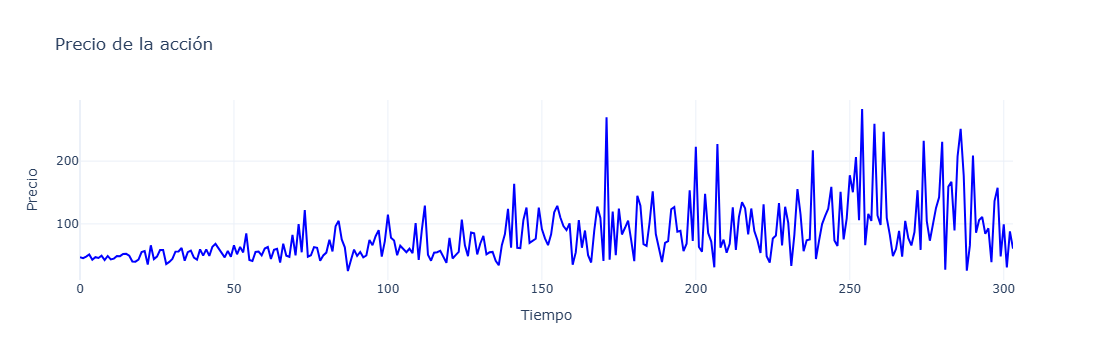

In [49]:
import plotly.graph_objects as go

# Obtener la columna (24ª columna) y su nombre
columna = df.iloc[:, 24]
nombre_columna = df.columns[24]

# Crear la gráfica interactiva
fig = go.Figure()

fig.add_trace(go.Scatter(
    y=columna,
    x=df.index,
    mode='lines',
    name=nombre_columna,
    line=dict(color='blue')
))

# Agregar título y etiquetas
fig.update_layout(
    title='Precio de la acción',
    xaxis_title='Tiempo',
    yaxis_title='Precio',
    template='plotly_white',
    hovermode='x unified'
)

fig.show()


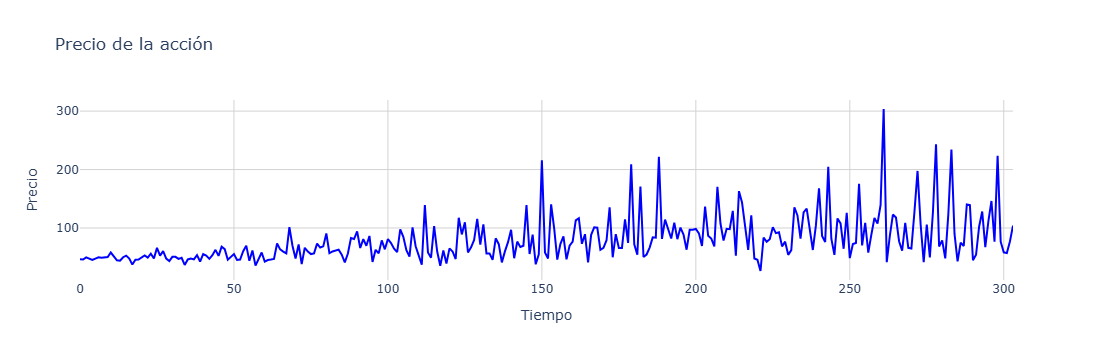

In [50]:
# Seleccionar la columna 8
columna = df.iloc[:, 8]
nombre_columna = df.columns[8]

# Crear la gráfica interactiva
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df.index,
    y=columna,
    mode='lines',
    name=nombre_columna,
    line=dict(color='blue')
))

# Personalizar el diseño
fig.update_layout(
    title="Precio de la acción",
    xaxis_title="Tiempo",
    yaxis_title="Precio",
    template="plotly_white",
    hovermode="x unified",
    xaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False),
    yaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False)
)

fig.show()


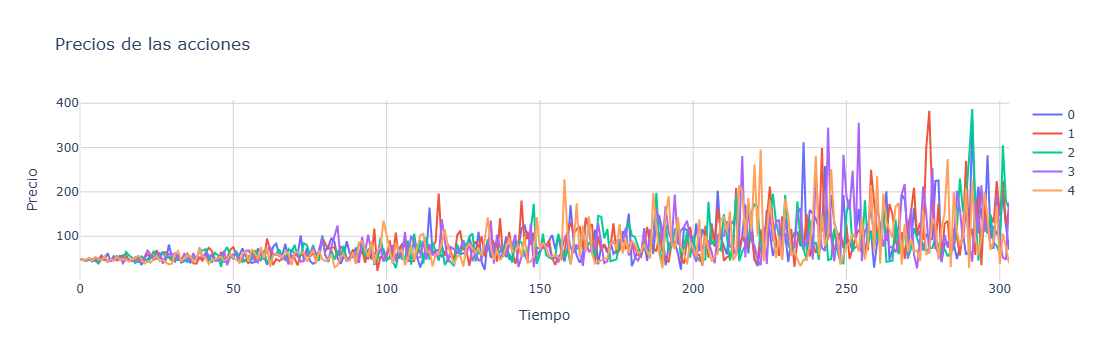

In [51]:
# Seleccionar las primeras 5 columnas
columnas = df.columns[:5]

# Crear figura
fig = go.Figure()

# Agregar una traza (línea) por cada columna
for col in columnas:
    fig.add_trace(go.Scatter(
        x=df.index,
        y=df[col],
        mode='lines',
        name=col
    ))

# Personalizar la gráfica
fig.update_layout(
    title="Precios de las acciones",
    xaxis_title="Tiempo",
    yaxis_title="Precio",
    template="plotly_white",
    hovermode="x unified",
    xaxis=dict(showgrid=True, gridcolor='lightgray'),
    yaxis=dict(showgrid=True, gridcolor='lightgray')
)

# Mostrar la gráfica
fig.show()


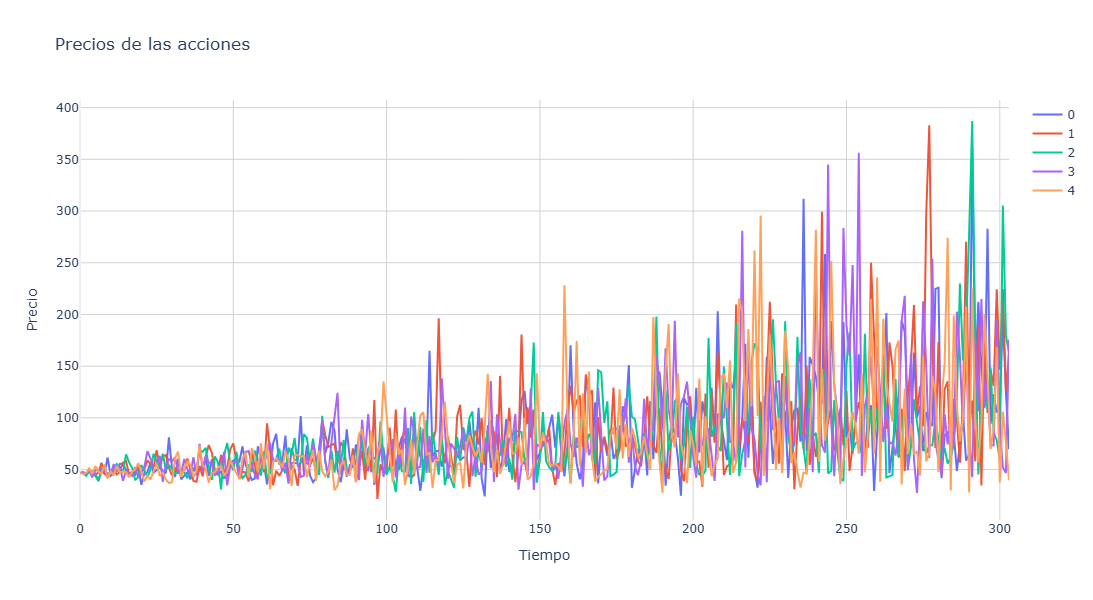

In [52]:
# Seleccionamos las primeras 5 columnas
columnas = df.columns[:5]

# Crear figura interactiva
fig = go.Figure()

# Añadir una línea por cada columna
for col in columnas:
    fig.add_trace(go.Scatter(
        x=df.index,
        y=df[col],
        mode='lines',
        name=col
    ))

# Personalización de la gráfica
fig.update_layout(
    title="Precios de las acciones",
    xaxis_title="Tiempo",
    yaxis_title="Precio",
    template="plotly_white",
    hovermode="x unified",
    width=1000,
    height=600,
    xaxis=dict(showgrid=True, gridcolor='lightgray'),
    yaxis=dict(showgrid=True, gridcolor='lightgray')
)

# Mostrar la gráfica
fig.show()


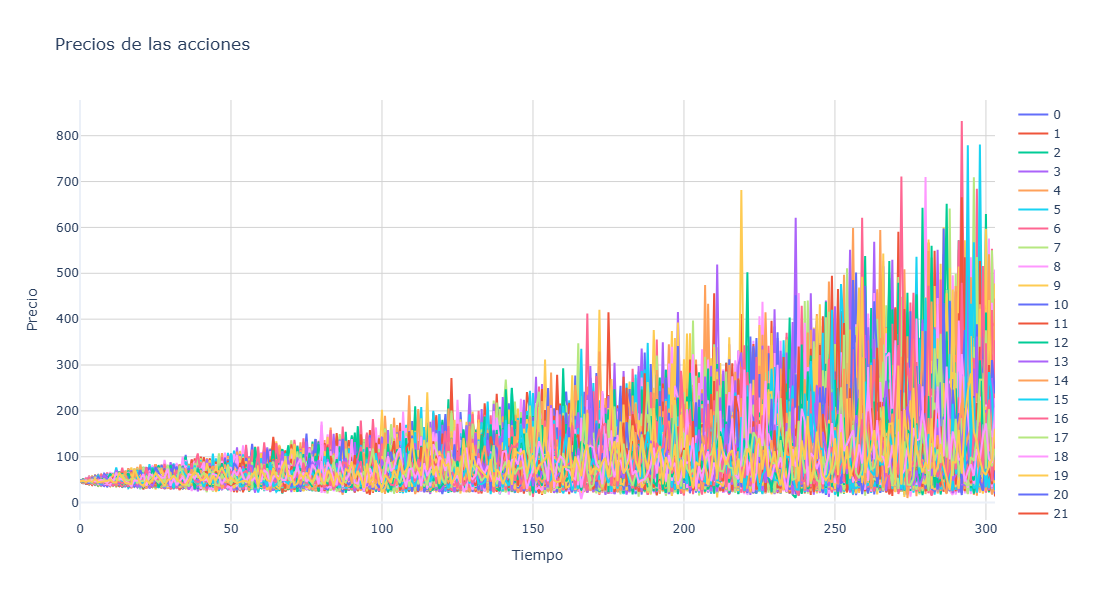

In [53]:
# Obtener todas las columnas del DataFrame
columnas = df.columns

# Crear figura
fig = go.Figure()

# Agregar una línea por cada columna
for col in columnas:
    fig.add_trace(go.Scatter(
        x=df.index,
        y=df[col],
        mode='lines',
        name=col
    ))

# Configuración del diseño
fig.update_layout(
    title="Precios de las acciones",
    xaxis_title="Tiempo",
    yaxis_title="Precio",
    template="plotly_white",
    hovermode="x unified",
    width=1000,
    height=600,
    xaxis=dict(showgrid=True, gridcolor='lightgray'),
    yaxis=dict(showgrid=True, gridcolor='lightgray')
)

# Mostrar la figura
fig.show()


## Lo que nos interesa es el promedio

In [37]:
# Obtenemos los promedios de cada fila
trayectoriaPromedio = df.mean(axis=1)
# Convertimos los promedios a un vector
trayectoriaPromedio = trayectoriaPromedio.values

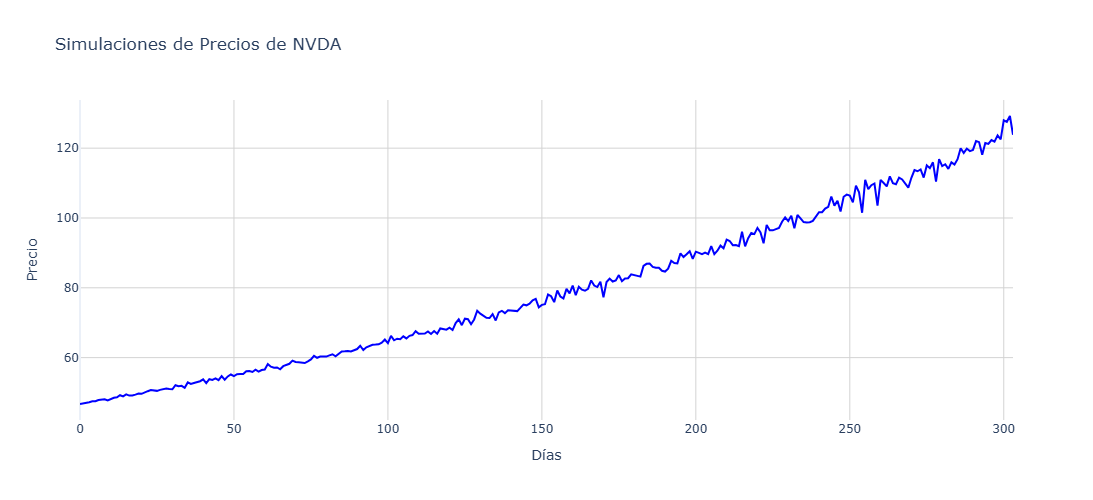

In [54]:
# Crear figura interactiva
fig = go.Figure()

# Agregar la trayectoria simulada
fig.add_trace(go.Scatter(
    y=trayectoriaPromedio,
    mode='lines',
    name=f"Simulación de {accion}",
    line=dict(color='blue')
))

# Personalizar la figura
fig.update_layout(
    title=f"Simulaciones de Precios de {accion}",
    xaxis_title="Días",
    yaxis_title="Precio",
    template="plotly_white",
    width=1000,
    height=500,
    hovermode="x unified",
    xaxis=dict(showgrid=True, gridcolor='lightgray'),
    yaxis=dict(showgrid=True, gridcolor='lightgray')
)

# Mostrar la gráfica
fig.show()


## Diferencias

In [41]:
trayectoriaPromedio[-5]

np.float64(122.5237496592805)

In [42]:
len(trayectoriaPromedio)

304

In [43]:
trayectoriaPromedio[-21]

np.float64(115.94750438931818)

In [44]:
max(trayectoriaPromedio)

np.float64(129.21572588025802)

In [45]:
posicion_maximo = trayectoriaPromedio.argmax()
posicion_maximo

np.int64(302)

In [46]:
print(f"La mejor posición es en {posicion_maximo-len(data)} períodos")

La mejor posición es en 3 períodos


In [47]:
data.tail()

Fecha  Precios NVDA  Retornos
Date                                         
2024-09-27 2024-09-27    121.365204 -0.021513
2024-09-30 2024-09-30    121.405190  0.000329
2024-10-01 2024-10-01    116.966461 -0.037246
2024-10-02 2024-10-02    118.815933  0.015688
2024-10-03 2024-10-03    122.814781  0.033102